In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcard-fraud-detection/cc_info.csv
/kaggle/input/creditcard-fraud-detection/transactions.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
card_info = pd.read_csv("/kaggle/input/creditcard-fraud-detection/cc_info.csv")
transactions_info = pd.read_csv("/kaggle/input/creditcard-fraud-detection/transactions.csv")

In [4]:
card_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [5]:
transactions_info.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [6]:
card_info.isnull().sum()

credit_card          0
city                 0
state                0
zipcode              0
credit_card_limit    0
dtype: int64

In [7]:
len(card_info)

984

In [8]:
transactions_info.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
dtype: int64

In [9]:
len(transactions_info)

294588

# EDA 

In [10]:
combined_data = transactions_info.merge(card_info, how = 'left', on = 'credit_card')

In [11]:
combined_data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [12]:
combined_data.shape

(294588, 9)

In [13]:
combined_data['date'] = pd.to_datetime(combined_data['date'])

In [14]:
combined_data['date_only'] = combined_data['date'].dt.strftime("%Y/%m/%d")
combined_data['time_only'] = combined_data['date'].dt.strftime("%H:%M:%S")
combined_data['hour_only'] = combined_data['date'].dt.strftime("%H")
combined_data['day_of_the_week'] = combined_data['date'].dt.strftime('%A')
combined_data['num_day'] = combined_data['date'].dt.strftime('%w')
combined_data['month_only'] = combined_data['date'].dt.strftime('%m')
combined_data['year_only'] = combined_data['date'].dt.strftime('%Y')

In [15]:
 combined_data =  combined_data.drop('date', axis = 1)

In [16]:
combined_data['time_only'] = combined_data['time_only'].replace('00','24')

In [17]:
combined_data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,date_only,time_only,hour_only,day_of_the_week,num_day,month_only,year_only
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,2015/09/11,00:32:40,00,Friday,5,09,2015
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,2015/10/24,22:23:08,22,Saturday,6,10,2015
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,2015/10/26,18:19:36,18,Monday,1,10,2015
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,2015/10/22,19:41:10,19,Thursday,4,10,2015
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,2015/10/26,20:08:22,20,Monday,1,10,2015


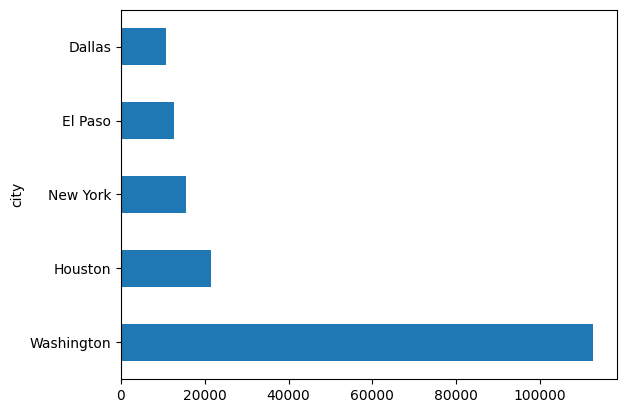

In [18]:
combined_data.city.value_counts().head().plot.barh()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


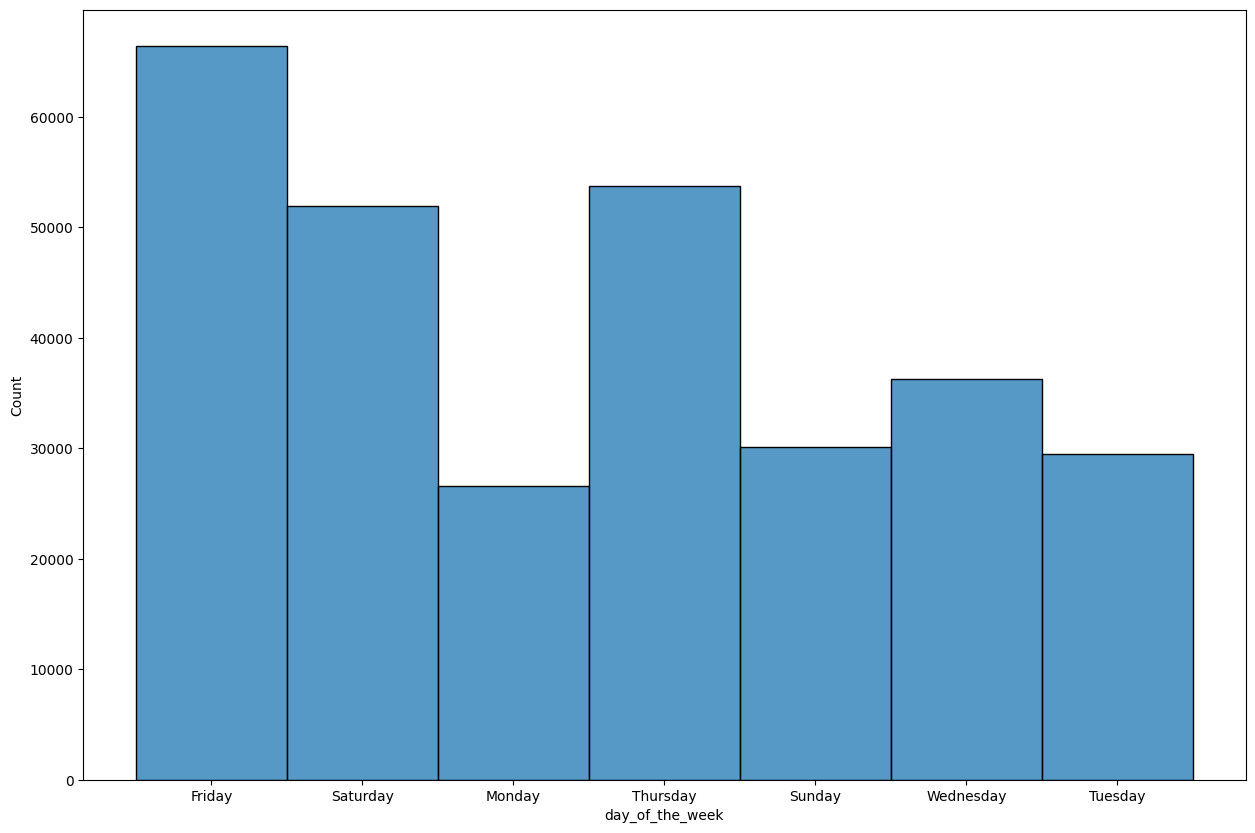

In [19]:
plt.figure(figsize = [15,10])
sns.histplot(data = combined_data, x= 'day_of_the_week')
plt.show()

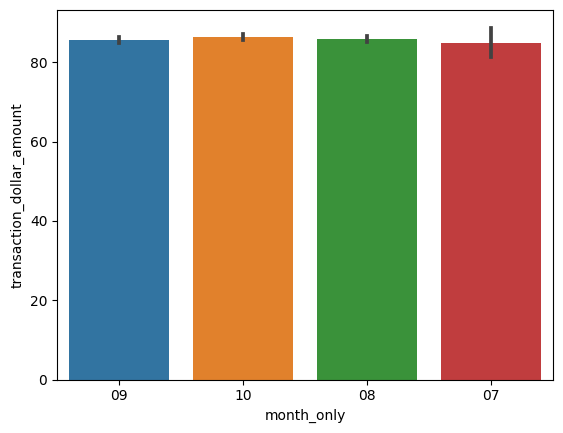

In [20]:
sns.barplot(data = combined_data, x = 'month_only', y= 'transaction_dollar_amount')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


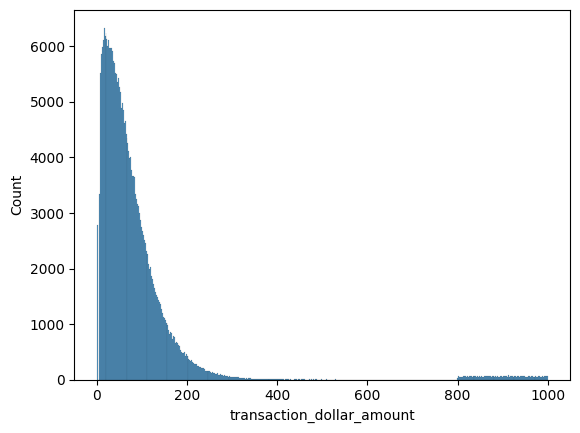

In [21]:
sns.histplot(data = combined_data, x= 'transaction_dollar_amount')
plt.show()

In [22]:
numeric_cols = []

for col in combined_data.columns:
    if pd.api.types.is_numeric_dtype(combined_data[col]):
        numeric_cols.append(col)

In [23]:
correlation_matrix = combined_data[numeric_cols].corr()

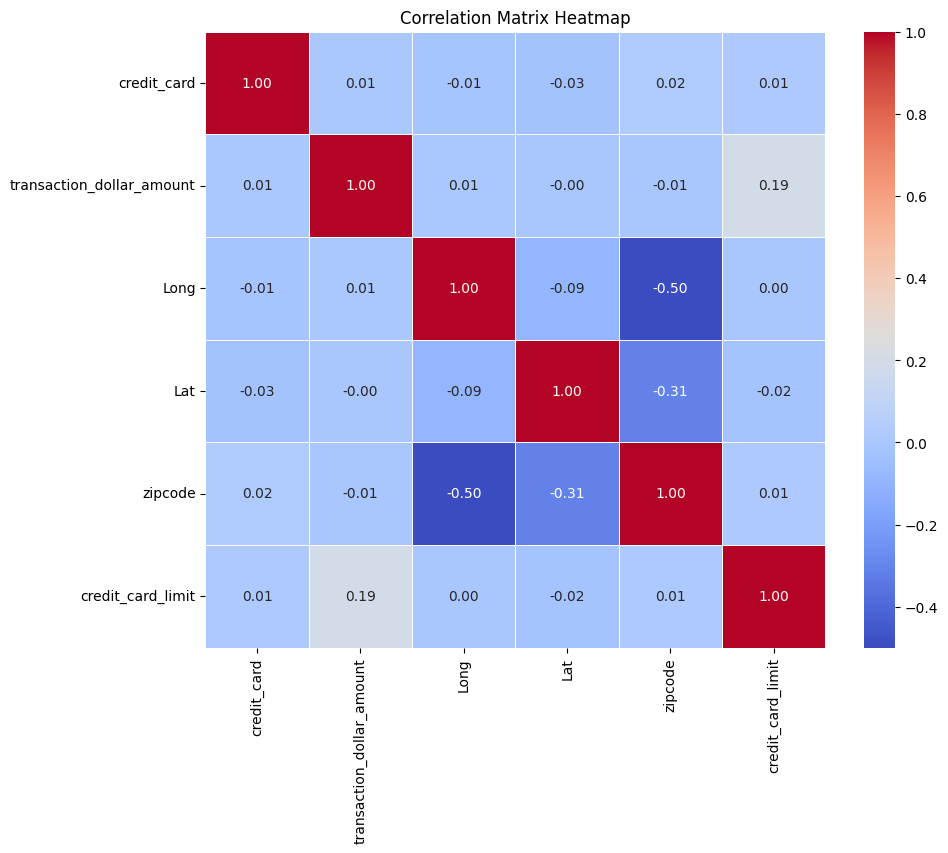

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [25]:
X_train, X_test = train_test_split(combined_data, test_size =0.2, random_state = 42)


In [26]:
enc = LabelEncoder()

# Fit the encoder on the training data and transform it
for col in X_train.columns:
    if X_train[col].dtype == object:
        X_train[col] = enc.fit_transform(X_train[col])

# Transform the test data using the fitted encoder
for col in X_test.columns:
    if X_test[col].dtype == object:
        X_test[col] = enc.fit_transform(X_test[col])


In [27]:
enc_numeric = StandardScaler()
X_train[numeric_cols] = enc_numeric.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = enc_numeric.fit_transform(X_test[numeric_cols])

In [28]:
model = KMeans(n_clusters= 3)
model.fit(X_train)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [29]:
pred = model.predict(X_test)
pred

array([1, 2, 2, ..., 1, 2, 1], dtype=int32)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


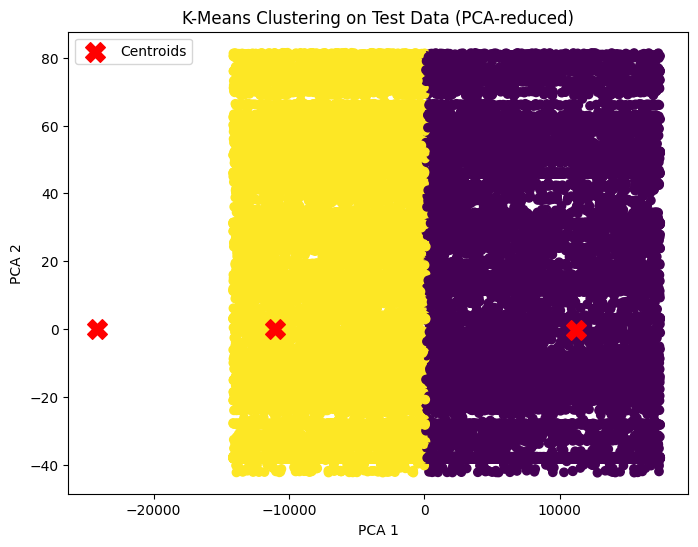

In [30]:
pca = PCA(n_components=2)

X_test_2d = pca.fit_transform(X_test)
centroids_2d = pca.transform(model.cluster_centers_)

plt.figure(figsize=(8, 6))

plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=pred, cmap='viridis', marker='o')


plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', s=200, marker='X', label='Centroids')

plt.title("K-Means Clustering on Test Data (PCA-reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()
